In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unrar x "/content/drive/MyDrive/Dataset_gauss.rar" "/content/drive/MyDrive/Data"

In [ ]:
!nvidia-smi

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from imutils import paths
import random
import shutil
import os

In [ ]:
BASE_PATH = "/content/drive/MyDrive/Park_gauss_vgg_new"

TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])

In [ ]:
imagePaths = list(paths.list_images("/content/drive/MyDrive/Data/Dataset_gauss"))
random.seed(42)
random.shuffle(imagePaths)

# compute the training and testing split
i = int(len(imagePaths) * 0.85)
trainPaths = imagePaths[:i]
valPaths = imagePaths[i:]

# define the datasets that we'll be building
datasets = [
	("training", trainPaths, TRAIN_PATH),
	("validation", valPaths, VAL_PATH)]

In [ ]:
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))

	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)

	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image along with its
		# corresponding class label
		filename = inputPath.split(os.path.sep)[-1]
		label = inputPath.split(os.path.sep)[-2]

		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])

		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)

		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)
        

        
# print("Training:")
# print("Images belonging to HC: ",len(os.listdir("C:\\Users\\kksat\\Desktop\\mini project\\Park_gauss_vgg\\training\\HC\\")))
# print("Images belonging to PD: ",len(os.listdir("C:\\Users\\kksat\\Desktop\\mini project\\Park_gauss_vgg\\training\\PD\\")))
# print("Validation:")
# print("Images belonging to HC: ",len(os.listdir("C:\\Users\\kksat\\Desktop\\mini project\\Park_gauss_vgg\\validation\\HC\\")))
# print("Images belonging to PD: ",len(os.listdir("C:\\Users\\kksat\\Desktop\\mini project\\Park_gauss_vgg\\validation\\PD\\")))

[INFO] building 'training' split
[INFO] 'creating /content/drive/MyDrive/Park_gauss_vgg_new/training' directory
[INFO] 'creating /content/drive/MyDrive/Park_gauss_vgg_new/training/PD_gauss' directory
[INFO] 'creating /content/drive/MyDrive/Park_gauss_vgg_new/training/HC_gauss' directory
[INFO] building 'validation' split
[INFO] 'creating /content/drive/MyDrive/Park_gauss_vgg_new/validation' directory
[INFO] 'creating /content/drive/MyDrive/Park_gauss_vgg_new/validation/HC_gauss' directory
[INFO] 'creating /content/drive/MyDrive/Park_gauss_vgg_new/validation/PD_gauss' directory


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainAug = ImageDataGenerator(
	rotation_range=25,
	zoom_range=0.1,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.2,
	horizontal_flip=True,
	fill_mode="nearest")

valAug = ImageDataGenerator()

In [ ]:
BS=64

trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(256, 256),
	color_mode="rgb",
	shuffle=True,
	batch_size=BS)

# initialize the validation generator
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(256, 256),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)
trainGen.samples

Found 6813 images belonging to 2 classes.
Found 1203 images belonging to 2 classes.


6813

In [ ]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = True

optimizer = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-5, mode='min', verbose=1)
model_chkpt = ModelCheckpoint('/content/drive/MyDrive/BestModel/Park_best_vgg_new.h5',save_best_only=True, monitor='val_loss',mode='min', verbose=1)

callback_list = [model_chkpt, lr_reduce]

In [ ]:
hist = model.fit(trainGen,
          validation_data = valGen,
          epochs=25,callbacks=callback_list)

Epoch 1/25
 10/107 [=>............................] - ETA: 4:01:09 - loss: 0.9856 - accuracy: 0.5094

KeyboardInterrupt: ignored

In [ ]:
bestmodel = model.load_weights('/content/drive/MyDrive/BestModel/Park_best_vgg.h5')
loss, acc = model.evaluate(valGen)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

19/19 [==============================] - 11s 547ms/step - loss: 0.3468 - accuracy: 0.8512
Restored model, accuracy: 85.12%


In [ ]:
model.fit(trainGen,
          validation_data = valGen,
          epochs=5,callbacks=callback_list)

Epoch 1/5
107/107 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.8336
Epoch 00001: val_loss improved from 0.34682 to 0.33959, saving model to /content/drive/MyDrive/BestModel/Park_best_vgg.h5
107/107 [==============================] - 237s 2s/step - loss: 0.3725 - accuracy: 0.8336 - val_loss: 0.3396 - val_accuracy: 0.8554 - lr: 4.0000e-05
Epoch 2/5
107/107 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.8518
Epoch 00002: val_loss did not improve from 0.33959
107/107 [==============================] - 224s 2s/step - loss: 0.3387 - accuracy: 0.8518 - val_loss: 0.3688 - val_accuracy: 0.8421 - lr: 4.0000e-05
Epoch 3/5
107/107 [==============================] - ETA: 0s - loss: 0.3229 - accuracy: 0.8560
Epoch 00003: val_loss did not improve from 0.33959
107/107 [==============================] - 224s 2s/step - loss: 0.3229 - accuracy: 0.8560 - val_loss: 0.3440 - val_accuracy: 0.8603 - lr: 4.0000e-05
Epoch 4/5
107/107 [=========================

In [ ]:
bestmodel = model.load_weights('/content/drive/MyDrive/BestModel/Park_best_vgg.h5')
loss, acc = model.evaluate(valGen)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

19/19 [==============================] - 11s 544ms/step - loss: 0.2833 - accuracy: 0.8861
Restored model, accuracy: 88.61%


In [ ]:
# valGen.reset()
# model.evaluate(valGen)

In [ ]:
model.fit(trainGen,
          validation_data = valGen,
          epochs=1,callbacks=callback_list)

#EVALUATION 

In [ ]:

model = keras.models.load_model('/content/drive/MyDrive/BestModel/Park_best_vgg.h5')

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras import backend as K
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

optimizer = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy",sensitivity,specificity])

In [ ]:
bestmodel = model.load_weights('/content/drive/MyDrive/BestModel/Park_best_vgg.h5')
loss, acc, sen, spec= model.evaluate(valGen)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

19/19 [==============================] - 143s 7s/step - loss: 0.2833 - accuracy: 0.8861 - sensitivity: 0.8846 - specificity: 0.8846
Restored model, accuracy: 88.61%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predIdxs = model.predict(valGen)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(valGen.classes, predIdxs, target_names=valGen.class_indices.keys()))

              precision    recall  f1-score   support

    HC_gauss       0.85      0.94      0.89       611
    PD_gauss       0.93      0.83      0.88       592

    accuracy                           0.89      1203
   macro avg       0.89      0.89      0.89      1203
weighted avg       0.89      0.89      0.89      1203



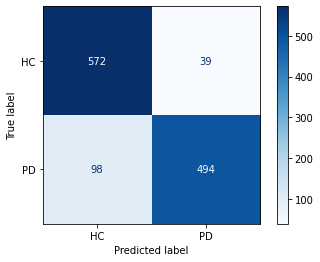

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(valGen.classes, predIdxs)
labels= ["HC", "PD"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()


## **EVALUATION ON TEST SET**

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
TEST_PATH = "/content/drive/MyDrive/Park_gauss_resnet_testset/testing/"

from tensorflow.keras.preprocessing.image import ImageDataGenerator

testAug = ImageDataGenerator()

BS=64

testGen = testAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(256, 256),
	color_mode="rgb",
	shuffle=False,
	batch_size=BS)

Found 1203 images belonging to 2 classes.


In [ ]:
model = load_model("/content/drive/MyDrive/BestModel/Park_best_vgg.h5")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predIdxs = model.predict(testGen)
predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

    HC_gauss       0.87      0.94      0.90       589
    PD_gauss       0.94      0.87      0.90       614

    accuracy                           0.90      1203
   macro avg       0.90      0.90      0.90      1203
weighted avg       0.90      0.90      0.90      1203



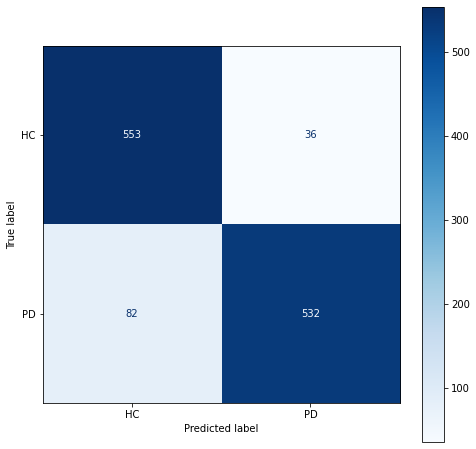

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(testGen.classes, predIdxs)
labels= ["HC", "PD"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax,cmap=plt.cm.Blues)